In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos


%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [2]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_matt'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


/data/scratch/rpa/SOSE/run_matt/XC.meta
/data/scratch/rpa/SOSE/run_matt/XG.meta
/data/scratch/rpa/SOSE/run_matt/YC.meta
/data/scratch/rpa/SOSE/run_matt/YG.meta
/data/scratch/rpa/SOSE/run_matt/DYC.meta
/data/scratch/rpa/SOSE/run_matt/DYG.meta
/data/scratch/rpa/SOSE/run_matt/DXC.meta
/data/scratch/rpa/SOSE/run_matt/DXG.meta
/data/scratch/rpa/SOSE/run_matt/RAC.meta
/data/scratch/rpa/SOSE/run_matt/RC.meta
/data/scratch/rpa/SOSE/run_matt/RF.meta
/data/scratch/rpa/SOSE/run_matt/DRC.meta
/data/scratch/rpa/SOSE/run_matt/DRF.meta
/data/scratch/rpa/SOSE/run_matt/Depth.meta
/data/scratch/rpa/SOSE/run_matt/hFacC.meta
/data/scratch/rpa/SOSE/run_matt/hFacS.meta
/data/scratch/rpa/SOSE/run_matt/hFacW.meta


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


## data.diagnostics ##

    frequency(1) = 2629200.0,
    fields(1,1) = 'SIarea  ',
                 'SIheff  ',
                 'SIhsnow ',
                 'SItflux ',
                 'SIatmQnt',
                 'SIempmr ',
                 'SIatmFW ',
                 'SIuheff ',
                 'SIvheff ',
                 'TFLUX   ',
                 'SFLUX   ',
                 'THETA   ',
                 'SALT    ',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-monthly',




In [3]:
# monthly stuff
deltaT = 900
#diag_freq = 2629200. # monthly
diag_freq = 432000 # 5-day
diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = np.round(np.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

# starts in January
months = np.tile(np.ceil((np.arange(0,365,5)+0.1)/(365/12.)), 6)
assert len(months) == Nt

# season definitions
# easy because we want to start with january
season = np.tile(np.repeat(np.arange(4),3), Nt/12)
season_names = ['JFM', 'AMJ', 'JAS', 'OND']
season_idx = {}
for n,s in enumerate(season_names):
    season_idx[s] = list(diag_iters[season==n])

In [4]:
diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT']
diag_prefix = 'DiagIce-5day'
data = dict((el,dict()) for el in diag_names)


# Comparison of Different Potential Density Routines #
## Surface Density in July ##

/data/scratch/rpa/SOSE/run_matt/DiagIce-5day.0000026400.meta
negative salinity values! setting to nan
/home/rpa/.local/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg/MITgcmutils/jmd95.py:124: RuntimeWarning: invalid value encountered in sqrt
/home/rpa/.local/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg/MITgcmutils/jmd95.py:176: RuntimeWarning: invalid value encountered in sqrt
/home/rpa/.local/lib/python2.7/site-packages/seawater/eos80.py:450: RuntimeWarning: invalid value encountered in sqrt
  s ** 0.5 + d * s ** 2)


26400


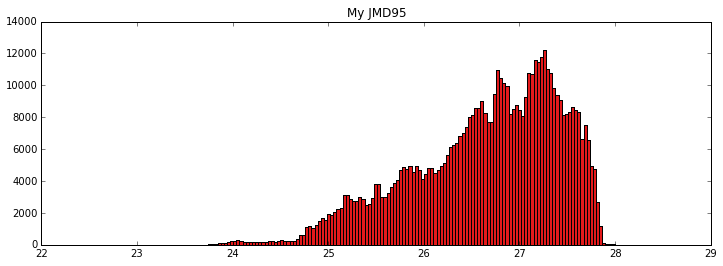

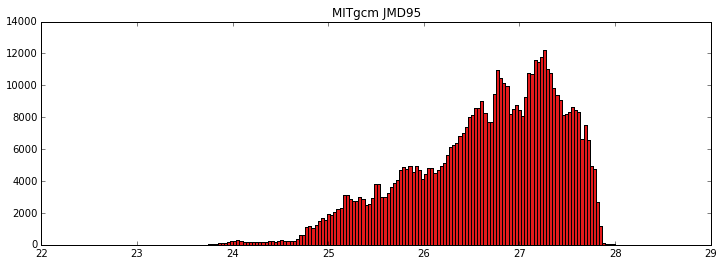

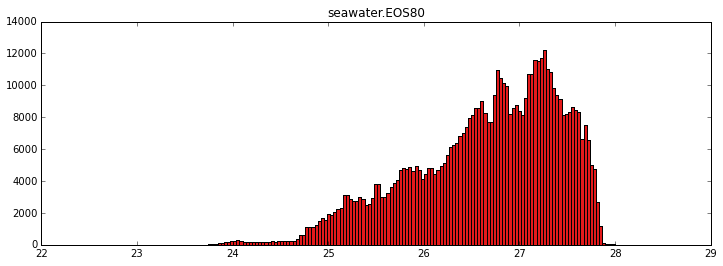

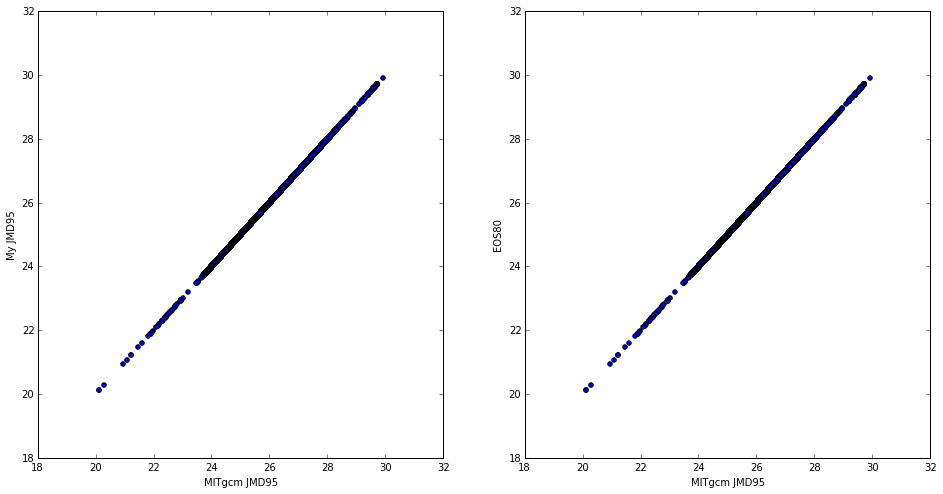

In [5]:
from MITgcmutils import jmd95
from seawater import eos80

# look at wintertime density
#niter = diag_iters[180/5]
niter = diag_iters[270/5]
draw = m.rdmds(diag_prefix, niter) # should give july
#draw = m.rdmds(diag_prefix, diag_iters[0])
d = {}
for n, dn in enumerate(diag_names):
    d[dn] = draw[n]
print niter

# comapre different densities
rho1, drhodt, drhods = eos.state_surface(d['THETA'], d['SALT'])
rho2 = jmd95.densjmd95(d['SALT'], d['THETA'], 0.)
rho3 = eos80.dens0(d['SALT'], d['THETA'])

for rho, tit in zip([rho1, rho2, rho3], ['My JMD95', 'MITgcm JMD95', 'seawater.EOS80']):
    plt.figure(figsize=(12,4))
    plt.hist(np.ma.masked_array(rho, m.mask[0]).compressed()-1000, bins=300);
    plt.title(tit)
    plt.xlim(22,29)

plt.figure()
plt.subplot(121)
plt.scatter(np.ma.masked_array(rho2, m.mask[0]).compressed()-1000, 
            np.ma.masked_array(rho1, m.mask[0]).compressed()-1000)
plt.xlabel('MITgcm JMD95')
plt.ylabel('My JMD95')
plt.subplot(122)
plt.scatter(np.ma.masked_array(rho2, m.mask[0]).compressed()-1000, 
            np.ma.masked_array(rho3, m.mask[0]).compressed()-1000)
plt.xlabel('MITgcm JMD95')
plt.ylabel('EOS80')


In [6]:
def flat(fld2d):
    #return np.ma.masked_array(fld2d, m.mask[0]).compressed()
    return np.ma.masked_array(fld2d, m.mask[0]).filled(0.).ravel()

pres = np.zeros_like(d['THETA']) + 10.

# neutral density
from pygamman import gamman as nds
reload(nds)
s, t, p, lon, lat = [flat(f) for f in [d['SALT'], d['THETA'], pres,
                                       m.xc, m.yc]]
N = len(s)
print s.shape

gamma, dglo, dghi = nds.gamma_n(s, t, p, N, lon, lat)
gamma.shape = (m.Ny,m.Nx)


ImportError: No module named pygamman

# Neutral Density #

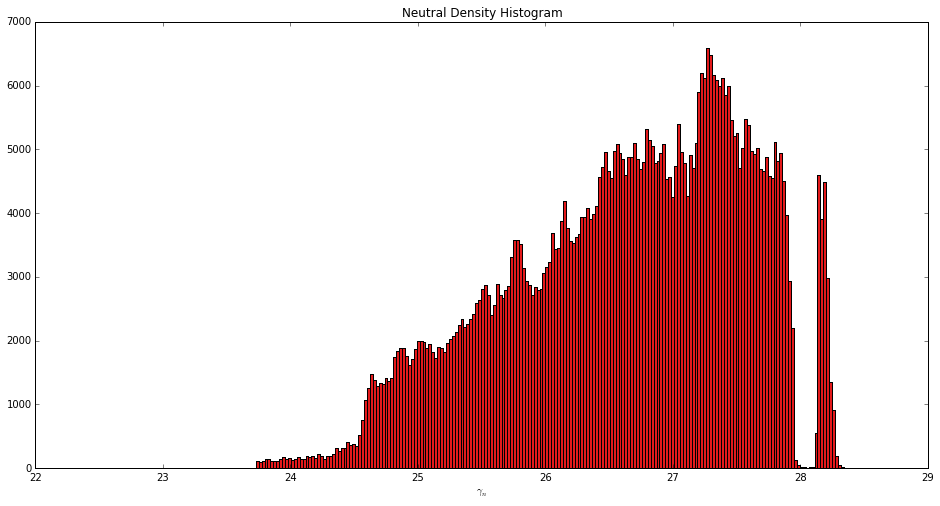

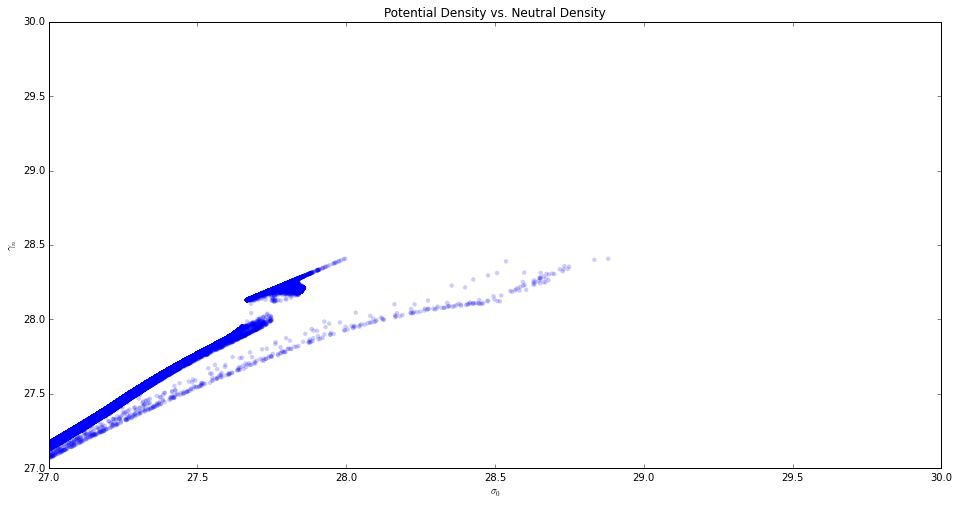

In [7]:
plt.figure()
gmask = (gamma<0) | (m.mask[0])
plt.hist(np.ma.masked_array(gamma,gmask).compressed(), bins=300);
plt.xlim(22,29)
plt.title('Neutral Density Histogram')
plt.xlabel(r'$\gamma_n$')

a = np.ma.masked_array(rho2-1000, gmask).compressed()
b = np.ma.masked_array(gamma,gmask).compressed()

plt.figure()
plt.scatter(a, b, edgecolor='none', alpha=0.2)
plt.ylim(27,30)
plt.xlim(27,30)
plt.title('Potential Density vs. Neutral Density')
plt.xlabel(r'$\sigma_0$')
plt.ylabel(r'$\gamma_n$')

<matplotlib.contour.QuadContourSet instance at 0x2b216f72fb90>

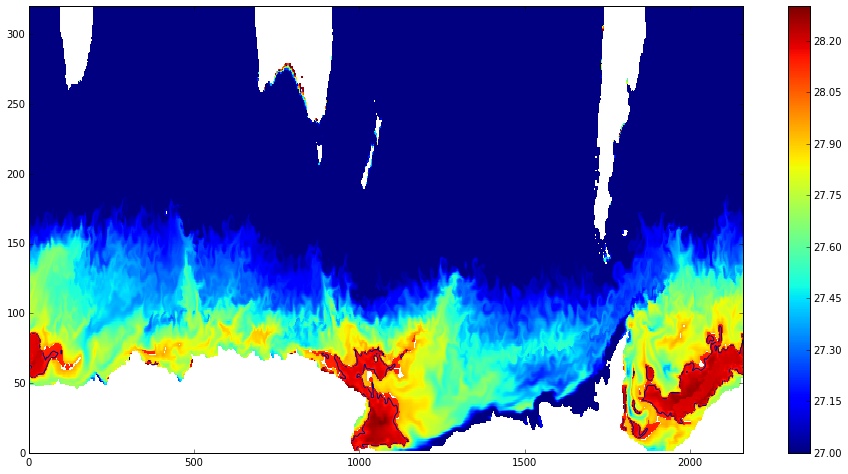

In [23]:
gamma.shape = (m.Ny,m.Nx)
g = np.ma.masked_less(np.ma.masked_array(gamma, m.mask[0]),0)
plt.pcolormesh(g)
plt.clim([27,28.3])
plt.colorbar()
plt.contour(g, [28.15,])


<matplotlib.contour.QuadContourSet instance at 0x2b216e331ab8>

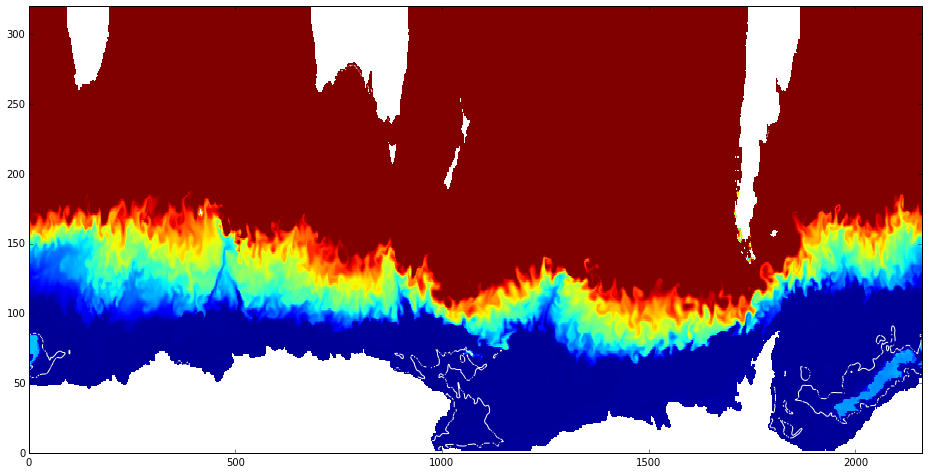

In [17]:
plt.pcolormesh(np.ma.masked_array(d['THETA'], m.mask[0]))
plt.clim([-2,4])
plt.contour(g, [28.15,], colors='w')


<matplotlib.contour.QuadContourSet instance at 0x2b216e055f38>

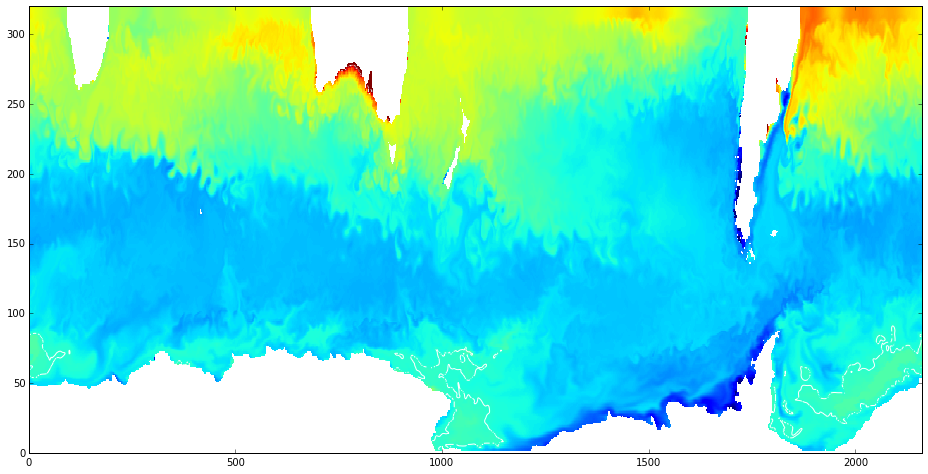

In [20]:
plt.pcolormesh(np.ma.masked_array(d['SALT'], m.mask[0]))
plt.clim([32,38])
plt.contour(g, [28.15,], colors='w')


In [87]:
# gradient comparison (for b factor)

def grad_mod_centered(T, maskc):
    # stuff for gradient
    # reciprocal of dx and dy (in meters)
    dxcr = m.dxc**-1
    dycr = m.dyc**-1
    maske = np.where(maskc & np.roll(maskc,-1,axis=-1), 1., 0.)
    maskn = np.where(maskc & np.roll(maskc,-1,axis=-2), 1., 0.)
    
    dTx = maske * (np.roll(T,-1,axis=-1) - T)
    dTy = maskn * (np.roll(T,-1,axis=-2) - T)

    return np.sqrt( 0.5 *
                (dTx**2 + np.roll(dTx,1,axis=-1)**2) * dxcr**2
               +(dTy**2 + np.roll(dTy,1,axis=-2)**2) * dycr**2
    )


In [90]:
grad_sig0 = grad_mod_centered(rho1, ~m.mask[0])
grad_gam = grad_mod_centered(gamma, ~(m.mask[0] | (gamma<0)))

-c:10: RuntimeWarning: invalid value encountered in divide
-c:10: RuntimeWarning: divide by zero encountered in log10


<matplotlib.colorbar.Colorbar instance at 0x2b0f2c4332d8>

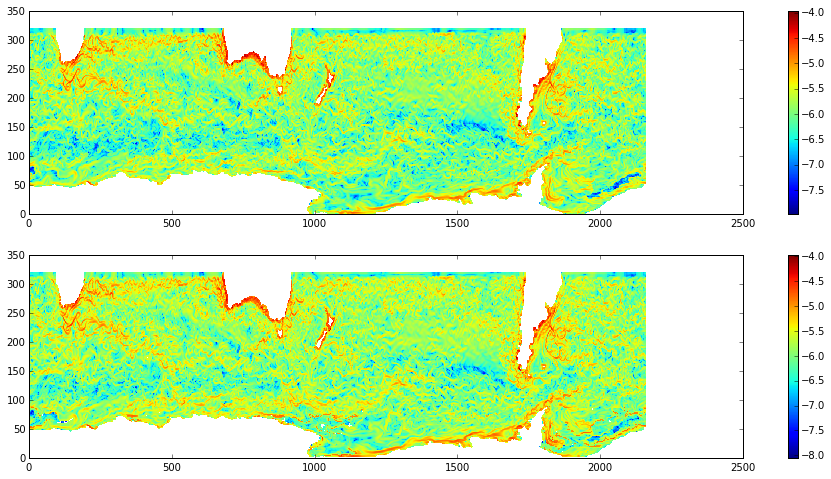

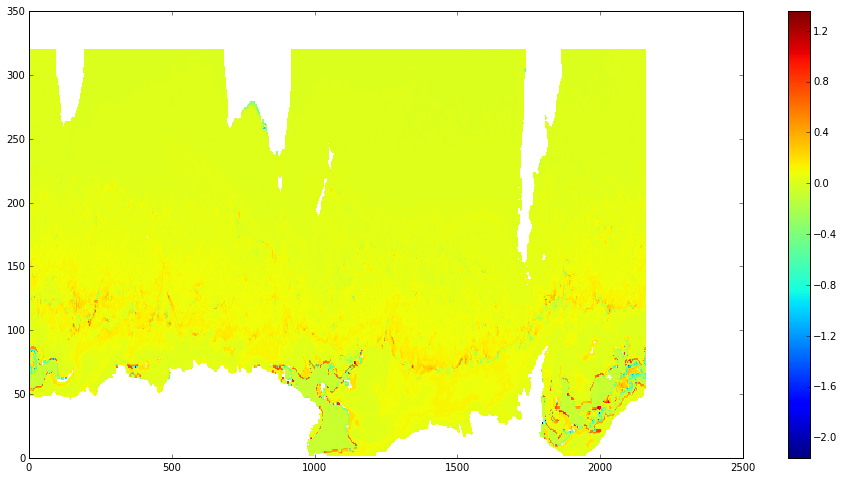

In [93]:
plt.subplot(211)
plt.pcolormesh(np.ma.masked_invalid(np.log10(grad_sig0[0])))
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(np.ma.masked_invalid(np.log10(grad_gam[0])))
plt.colorbar()


plt.figure()
plt.pcolormesh(np.ma.masked_invalid(np.log10(grad_gam[0] / grad_sig0[0])))
plt.colorbar()


In [104]:
from astropy.convolution import Gaussian2DKernel, convolve

# apply smoothing to fields
def smooth_2d(fld, width=4):
    ker = Gaussian2DKernel(width)
    res = convolve(np.ma.masked_array(fld).filled(np.nan),
                   ker, fill_value=np.nan)
    return np.ma.masked_invalid(res)


In [105]:
grad_sig0_smo = smooth_2d(np.ma.masked_array(grad_sig0[0], gmask))
grad_gamma_smo = smooth_2d(np.ma.masked_array(grad_gam[0], gmask))


<matplotlib.colorbar.Colorbar instance at 0x2b0f2d505ef0>

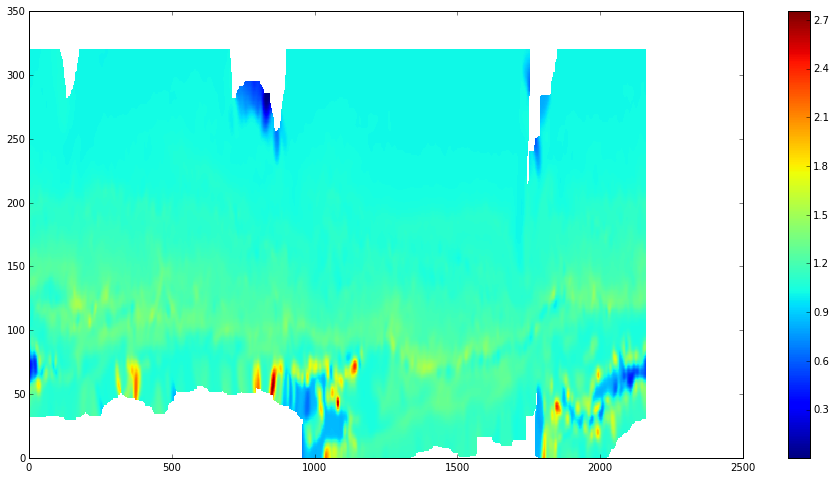

In [107]:
plt.figure()
plt.pcolormesh(grad_gamma_smo / grad_sig0_smo)
plt.colorbar()

In [108]:
from MITgcmutils import wrmds

In [109]:
wrmds?

In [10]:
t.min()

-1.9363090991973877